<a href="https://colab.research.google.com/github/sutanto5/DataScience-Exploration/blob/main/JS_MLS2_HeartClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import shap
import plotly.express as px

# **Data Preparation and Analysis**


---


Clean and preprocess the dataset

Handle missing values and outliers using medical domain knowledge

Feature engineering (optional):

Create new features (BMI, combined risk factors)

Develop risk index scores

Normalize/standardize features appropriately

Perform exploratory data analysis with medical context

Analyze feature correlations

Apply feature selection methods

Address class imbalance if present (SMOTE, class weights) (optional)

---



EDA

In [69]:
# import heart.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('heart.csv')
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  


In [70]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [72]:
print(df.isnull().sum())
#no null so don't need to clean the data

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<Axes: >

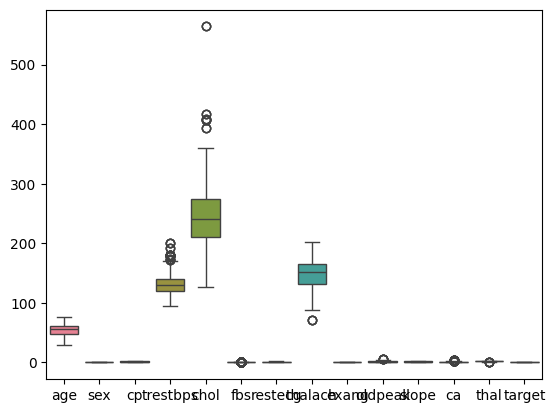

In [73]:
#white dots are outliers
import seaborn as sns
sns.boxplot(df)

In [74]:
#remove duplicates
df.duplicated().sum()
df_no_duplicates = df.drop_duplicates()

In [75]:
#This function removes all outleirs. from the data using IQR method
#input: dataframe, and threshold
#output: dataframe without outliers
def remove_outliers_iqr_all(data, threshold=1.5):

    df = data.copy()
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

<Axes: >

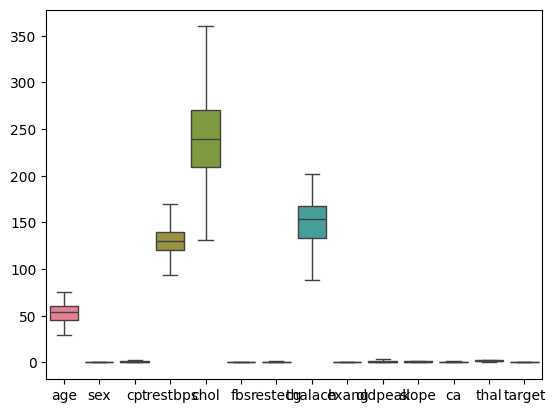

In [76]:
#removing outliers
df = remove_outliers_iqr_all(df)
df.head()

#no more outliers! Yay!
sns.boxplot(df)

In [77]:
# Calculate BMI
#df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
#Figure out how to feature engineer BMI

Correlation

<Axes: xlabel='age', ylabel='chol'>

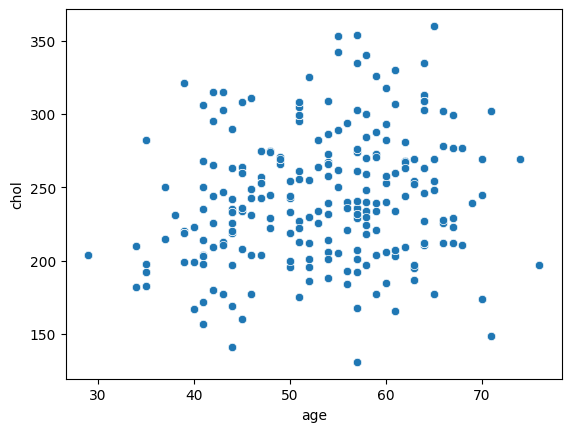

In [78]:
#age in comparison to cholestrol
sns.scatterplot(data=df, x='age', y='chol')

In [79]:
#find correlation coefficient
corr = df['age'].corr(df['chol'])

print(f"The correlation between age and cholestrol is " + str(corr))

The correlation between age and cholestrol is 0.17627851695588762


In [80]:
corr = df['age'].corr(df['trestbps'])

#there is slight correlation between age and resting blood pressure
print(f"The correlation between age and trestbps is " + str(corr))

The correlation between age and trestbps is 0.2635570534547698


In [88]:
df.corr()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,trestbps_scaled
age,1.000000,-0.089713,-0.076169,0.263557,0.176279,NaN,-0.103479,-0.398649,0.114700,0.219267,-0.161366,0.390240,0.131007,-0.220869,0.263557
sex,-0.089713,1.000000,-0.113030,-0.010044,-0.091599,NaN,-0.116547,-0.092440,0.209085,0.170831,-0.010218,0.105541,0.270474,-0.367541,-0.010044
cp,-0.076169,-0.113030,1.000000,0.086497,-0.041429,NaN,0.074280,0.288103,-0.358065,-0.131628,0.104855,-0.205129,-0.152233,0.374184,0.086497
trestbps,0.263557,-0.010044,0.086497,1.000000,0.123074,NaN,-0.125076,-0.014083,-0.037887,0.115325,-0.020313,0.023972,0.051163,-0.085923,1.000000
chol,0.176279,-0.091599,-0.041429,0.123074,1.000000,NaN,-0.096983,-0.020648,0.022500,-0.028916,0.055897,0.110865,0.081953,-0.080868,0.123074
fbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,-0.103479,-0.116547,0.074280,-0.125076,-0.096983,NaN,1.000000,0.038942,-0.055491,-0.081289,0.094971,-0.093310,0.006223,0.128416,-0.125076
thalach,-0.398649,-0.092440,0.288103,-0.014083,-0.020648,NaN,0.038942,1.000000,-0.455154,-0.376230,0.424558,-0.272514,-0.207425,0.416945,-0.014083
exang,0.114700,0.209085,-0.358065,-0.037887,0.022500,NaN,-0.055491,-0.455154,1.000000,0.379601,-0.288091,0.207471,0.261245,-0.416859,-0.037887
oldpeak,0.219267,0.170831,-0.131628,0.115325,-0.028916,NaN,-0.081289,-0.376230,0.379601,1.000000,-0.507931,0.343393,0.219786,-0.443599,0.115325


Standardization

<Axes: xlabel='age', ylabel='trestbps'>

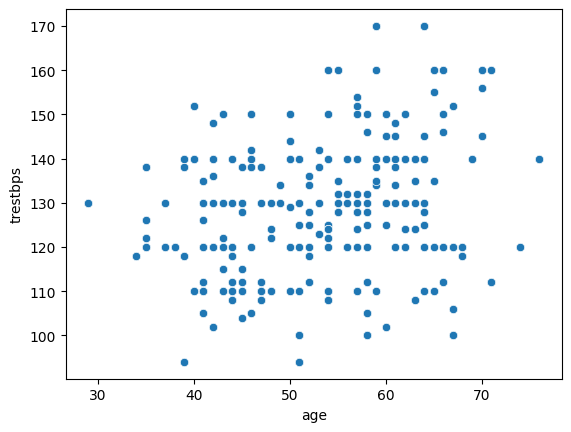

In [53]:
sns.scatterplot(data=df, x='age', y='trestbps')

Standardization
 - scales the model using mean and standard dev
 - both set to 0

(array([  7.,   0.,  14.,   9.,  12.,  18.,  60.,  30.,   6.,  20., 114.,
         35.,  27.,  26.,  94.,  32.,  24.,  27.,  89.,   3.,  22.,   7.,
         49.,   4.,   6.,   0.,  23.,   0.,   0.,  11.]),
 array([-2.2664052 , -2.10087229, -1.93533937, -1.76980645, -1.60427353,
        -1.43874061, -1.2732077 , -1.10767478, -0.94214186, -0.77660894,
        -0.61107602, -0.4455431 , -0.28001019, -0.11447727,  0.05105565,
         0.21658857,  0.38212149,  0.5476544 ,  0.71318732,  0.87872024,
         1.04425316,  1.20978608,  1.37531899,  1.54085191,  1.70638483,
         1.87191775,  2.03745067,  2.20298359,  2.3685165 ,  2.53404942,
         2.69958234]),
 <BarContainer object of 30 artists>)

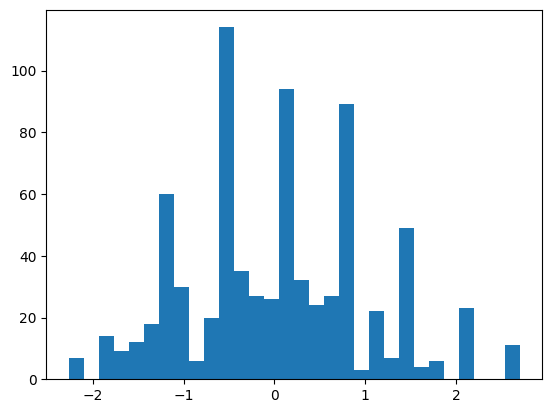

In [82]:
#trestbps before standardization
plt.hist(df['trestbps'], bins=30)

In [83]:
scaled_data = StandardScaler().fit_transform(df[['trestbps']])

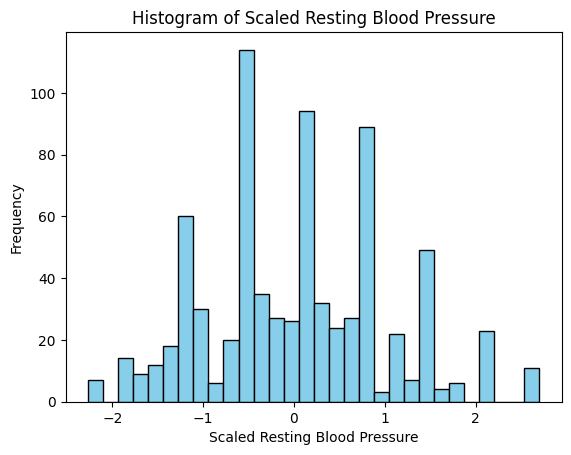

In [87]:
plt.hist(df['trestbps_scaled'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Scaled Resting Blood Pressure')
plt.xlabel('Scaled Resting Blood Pressure')
plt.ylabel('Frequency')
plt.show()


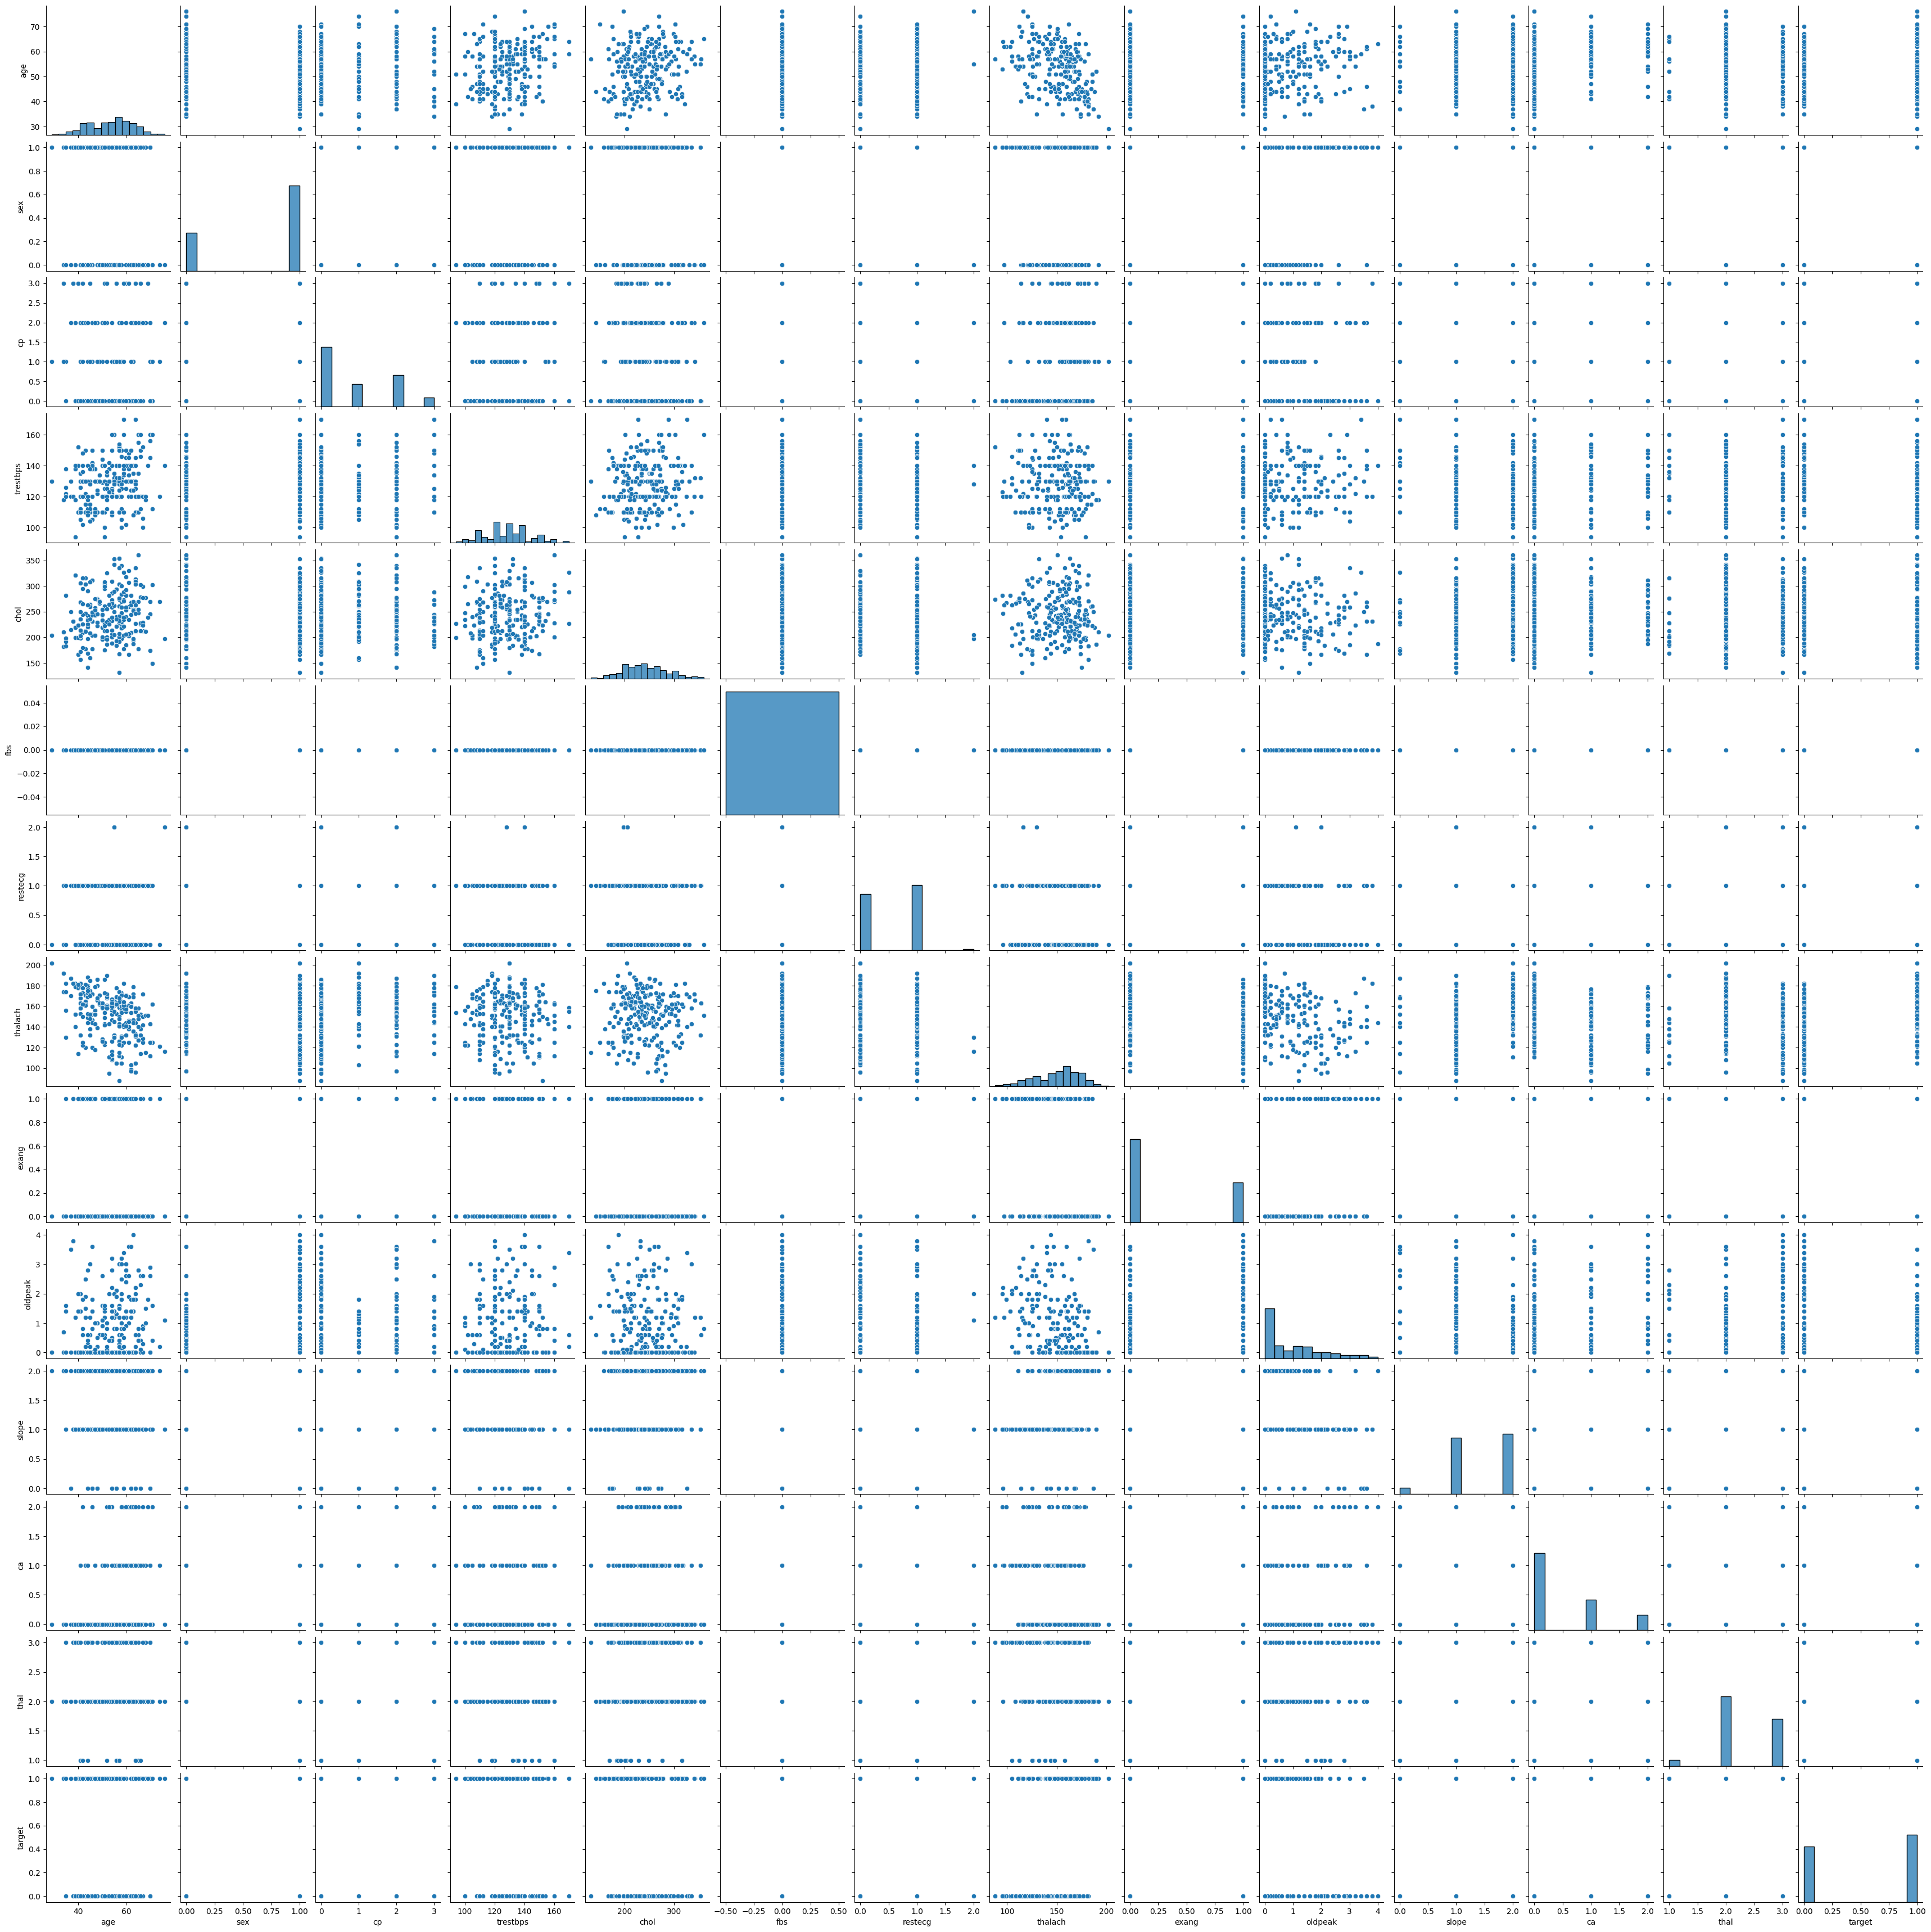

In [38]:
#I thought this was cool
sns.pairplot(df)

applying feature selection methods

In [89]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X = df.drop('target', axis=1)
y = df['target']
X_new = selector.fit_transform(X, y)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [5] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


# **Model Development**

# **Clincial Relevance**